# SmoothQuant on Llama 2 7B

In this notebook, we use Llama-2-7B model to demonstrate SmoothQuant can use 8-bit for both weights and activations to achieve the similar perplexity as FP16 models.

In order to run this notebook, you need to install the following packages:

- smoothquant
- PyTorch
- Transformers
- Accelerate

In [1]:
import sys
sys.path.append('../smoothquant')
from fake_quant import quantize_attention_only
from smooth import smooth_lm_attention_only
from fake_quant import *

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import torch
import torch.nn as nn
from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    LlamaDecoderLayer,
    LlamaForCausalLM,
    LlamaMLP,
)
from transformers import LlamaTokenizer
from smoothquant.smooth import smooth_lm
from smoothquant.fake_quant import quantize_llama_like
import tqdm

The following is an evaluator to see the performance of the model. We use a toy dataset (the first 40 examples in the test set of the Wikitext-2 dataset) to evaluate the model. You can replace it with your own dataset. The conclusion should be the same.

In [3]:
class Evaluator:
    def __init__(self, dataset, tokenizer, device, n_samples=40):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.device = device

        self.dataset = tokenizer(
            "\n\n".join(dataset["text"]), return_tensors="pt"
        ).input_ids.to(device)

        self.n_samples = n_samples

    @torch.no_grad()
    def evaluate(self, model):
        model.eval()
        nlls = []
        for i in tqdm.tqdm(range(self.n_samples), desc="Evaluating..."):
            batch = self.dataset[:, (i * 2048) : ((i + 1) * 2048)].to(model.device)
            with torch.no_grad():
                lm_logits = model(batch).logits
            shift_logits = lm_logits[:, :-1, :].contiguous().float()
            shift_labels = self.dataset[:, (i * 2048) : ((i + 1) * 2048)][:, 1:]
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)
            )
            neg_log_likelihood = loss.float() * 2048
            nlls.append(neg_log_likelihood)

        return torch.exp(torch.stack(nlls).sum() / (self.n_samples * 2048))

In [4]:
from datasets import load_dataset

tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
evaluator = Evaluator(dataset, tokenizer, "cuda")

/home/master_112/m56121041/miniconda3/envs/smoothquant/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [5]:
import functools

def get_act_scales(model):
    model.eval() # Set the model to evaluation mode
    act_scales_all = {}  # Dictionary to store the activations of all layers

    def stat_tensor(name, tensor):
        hidden_dim = tensor.shape[-1]
        # shape: (batch_size, seq_len, hidden_dim) -> (batch_size * seq_len, hidden_dim)
        # clone() is used to prevent modifying the original tensor
        tensor_original = tensor.clone().view(-1, hidden_dim).detach()
        act_scales_all[name] = tensor_original

    # module: is the layer being hooked
    def stat_input_hook(module, input, output, name):
        input_tensor = input[0] if isinstance(input, tuple) else input
        stat_tensor(name, input_tensor)

    hooks = []
    for name, module in model.named_modules():
        # if isinstance(module, (nn.Linear, W8A8Linear)):
        if isinstance(module, (nn.Linear,W8A8Linear,W4A4Linear)):
            print(f"Hooking layer: {name}")
            hook = module.register_forward_hook(
                functools.partial(stat_input_hook, name=name)
            )
            hooks.append(hook)

    # Generate a sample input
    tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    
    # Load WikiText-2 dataset
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    
    # Get a random sample from the dataset
    sample = dataset[torch.randint(len(dataset), (1,)).item()]["text"]
    print("Random sample text:", sample)  # 查看隨機取出的文字
    
    # Tokenize the sample
    input_ids = tokenizer(sample, return_tensors="pt", truncation=True, padding="max_length", max_length=1024
    ).input_ids
    
    # Move input_ids to the same device as the model
    input_ids = input_ids.to(model.device)

    # Forward pass
    with torch.no_grad():
        model(input_ids)

    for hook in hooks:
        hook.remove()

    return act_scales_all

## Attn quant only

### Attn to 8bit

#### processing model

In [11]:
model_fp16 = LlamaForCausalLM.from_pretrained(
    "../../llama-2-7b-hf", torch_dtype=torch.float16, device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
act_scales = torch.load("../act_scales/llama-2-7b.pt")
smooth_lm_attention_only(model_fp16, act_scales, 0.85)

Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.L

In [13]:
model_attn_only = quantize_attention_only(model_fp16)
print(model_attn_only )

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W8A8Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn):

In [14]:
ppl_attn = evaluator.evaluate(model_attn_only)
print(f"Original model (fp16) perplexity: {ppl_attn}")

Evaluating...: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Original model (fp16) perplexity: 5.833231449127197


#### hook activation

In [26]:
def get_act_scales_top3(model):
    model.eval()  # Set the model to evaluation mode
    act_scales_all = {}  # Dictionary to store the activations of all layers
    top3_act_scales_all = {}  # Dictionary to store the top 3 activations and their indices

    def stat_tensor(name, tensor):
        hidden_dim = tensor.shape[-1]
        # shape: (batch_size, seq_len, hidden_dim) -> (batch_size * seq_len, hidden_dim)
        tensor_original = tensor.clone().view(-1, hidden_dim).detach()
        act_scales_all[name] = tensor_original

        # 計算每個 token 的前三大值及其對應的 hidden dim 的 id
        top3_values, top3_indices = torch.topk(tensor_original, 3, dim=-1)
        top3_act_scales_all[name] = (top3_values, top3_indices)

    # module: is the layer being hooked
    def stat_input_hook(module, input, output, name):
        input_tensor = input[0] if isinstance(input, tuple) else input
        stat_tensor(name, input_tensor)

    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear,W8A8Linear,W4A4Linear)):
            print(f"Hooking layer: {name}")
            hook = module.register_forward_hook(
                functools.partial(stat_input_hook, name=name)
            )
            hooks.append(hook)

    # Generate a sample input
    tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    
    # Load WikiText-2 dataset
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    
    # Get a random sample from the dataset
    sample = dataset[torch.randint(len(dataset), (1,)).item()]["text"]
    print("Random sample text:", sample)  # 查看隨機取出的文字
    
    # Tokenize the sample
    input_ids = tokenizer(sample, return_tensors="pt", truncation=True, max_length=1024).input_ids
    
    # Move input_ids to the same device as the model
    input_ids = input_ids.to(model.device)

    # Forward pass
    with torch.no_grad():
        model(input_ids)

    for hook in hooks:
        hook.remove()

    return act_scales_all, top3_act_scales_all

In [27]:
act_scales_all,  top3_act_scales_all= get_act_scales_top3(model_attn_only)

Hooking layer: model.layers.0.self_attn.q_proj
Hooking layer: model.layers.0.self_attn.k_proj
Hooking layer: model.layers.0.self_attn.v_proj
Hooking layer: model.layers.0.self_attn.o_proj
Hooking layer: model.layers.0.mlp.gate_proj
Hooking layer: model.layers.0.mlp.up_proj
Hooking layer: model.layers.0.mlp.down_proj
Hooking layer: model.layers.1.self_attn.q_proj
Hooking layer: model.layers.1.self_attn.k_proj
Hooking layer: model.layers.1.self_attn.v_proj
Hooking layer: model.layers.1.self_attn.o_proj
Hooking layer: model.layers.1.mlp.gate_proj
Hooking layer: model.layers.1.mlp.up_proj
Hooking layer: model.layers.1.mlp.down_proj
Hooking layer: model.layers.2.self_attn.q_proj
Hooking layer: model.layers.2.self_attn.k_proj
Hooking layer: model.layers.2.self_attn.v_proj
Hooking layer: model.layers.2.self_attn.o_proj
Hooking layer: model.layers.2.mlp.gate_proj
Hooking layer: model.layers.2.mlp.up_proj
Hooking layer: model.layers.2.mlp.down_proj
Hooking layer: model.layers.3.self_attn.q_proj

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Random sample text:  Tetrarchs did not see any further combat and were deemed obsolete by 1946 ; the last was retired in 1950 . There were several variations on the Tetrarch design , including the Alecto self @-@ propelled gun and the Light Tank Mk VIII , but none of these were ever used in active service with the British Army . 



In [38]:
import pickle

# 保存 activation 到檔案
with open('activations_qattnw8.pkl', 'wb') as f:
    pickle.dump((act_scales_all, top3_act_scales_all), f)
"""
import pickle

# 從檔案讀取 activation
with open('activations.pkl', 'rb') as f:
    act_scales_all, top3_act_scales_all = pickle.load(f)

# 確認讀取的資料
for name, tensor in act_scales_all.items():
    print(f"Layer: {name}, Activation Shape: {tensor.shape}")

    """


'\nimport pickle\n\n# 從檔案讀取 activation\nwith open(\'activations.pkl\', \'rb\') as f:\n    act_scales_all, top3_act_scales_all = pickle.load(f)\n\n# 確認讀取的資料\nfor name, tensor in act_scales_all.items():\n    print(f"Layer: {name}, Activation Shape: {tensor.shape}")\n\n    '

In [32]:
k_proj_weights = model_attn_only.model.layers[0].self_attn.k_proj.weight
print("Weights of model.layers.0.self_attn.k_proj:")
print(k_proj_weights)


Weights of model.layers.0.self_attn.k_proj:
Parameter containing:
tensor([[-0.0031,  0.0000, -0.0000,  ...,  0.0031, -0.0000, -0.0000],
        [ 0.0042,  0.0000,  0.0000,  ..., -0.0042,  0.0000,  0.0000],
        [-0.0065, -0.0033,  0.0000,  ...,  0.0000, -0.0033, -0.0000],
        ...,
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],
       device='cuda:0', dtype=torch.float16, requires_grad=True)


In [28]:
for name, tensor in act_scales_all.items():
    print(f"Layer: {name}, Activation Shape: {tensor.shape}")

Layer: model.layers.0.self_attn.q_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.0.self_attn.k_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.0.self_attn.v_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.0.self_attn.o_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.0.mlp.gate_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.0.mlp.up_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.0.mlp.down_proj, Activation Shape: torch.Size([86, 11008])
Layer: model.layers.1.self_attn.q_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.1.self_attn.k_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.1.self_attn.v_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.1.self_attn.o_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.1.mlp.gate_proj, Activation Shape: torch.Size([86, 4096])
Layer: model.layers.1.mlp.up_proj, Activa

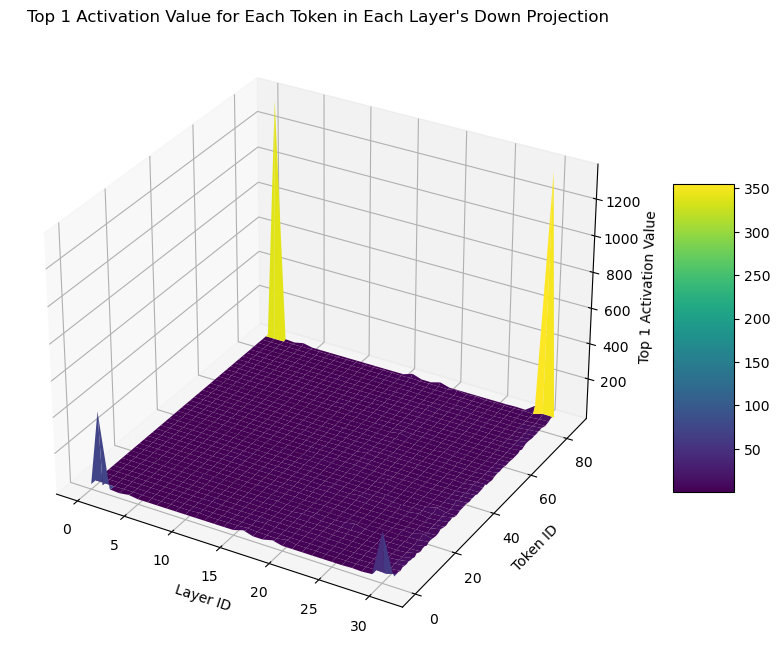

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# 繪製 down_proj 層的 top1 值
token_ids = range(86)
layer_ids = range(32)
top1_values_matrix = []

for i in layer_ids:
    layer_name = f"model.layers.{i}.mlp.down_proj"
    if layer_name in top3_act_scales_all:
        top1_values = top3_act_scales_all[layer_name][0][:, 0]  # 取出 top1 值
        top1_values_matrix.append(top1_values.cpu().numpy())  # 將值轉換為 numpy 並添加到矩陣中

top1_values_matrix = np.array(top1_values_matrix)

# 創建三維圖表
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 準備數據
X, Y = np.meshgrid(layer_ids, token_ids)
Z = top1_values_matrix.T  # 轉置矩陣以匹配 X 和 Y 的形狀

# 繪製曲面
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# 添加標籤和標題
ax.set_xlabel('Layer ID')
ax.set_ylabel('Token ID')
ax.set_zlabel('Top 1 Activation Value')
ax.set_title('Top 1 Activation Value for Each Token in Each Layer\'s Down Projection')

# 添加顏色條
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

#### text gen

In [33]:
from transformers import AutoModelForCausalLM, LlamaTokenizer, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
tokenizer = AutoTokenizer.from_pretrained("../../llama-2-7b-hf")

model_attn_only.eval()
model_attn_only = model_attn_only.to(device)

input_text = "explain what is AI"
inputs = tokenizer(input_text, return_tensors="pt",add_special_tokens=True).to(device)

output = model_attn_only.generate(
    inputs.input_ids,
    max_length=50,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
)

generated_text = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print("Generated text:", generated_text)

Using device: cuda
Generated text: ['explain what is AI and what is ML\nAi and ML are both machine learning techniques, but they are not the same. AI is a broader term that refers to any technology that allows machines to perform tasks that would normally require']


### Attn to 4bit

In [10]:
model_fp16 = LlamaForCausalLM.from_pretrained(
    "../../llama-2-7b-hf", torch_dtype=torch.float16, device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
act_scales = torch.load("../act_scales/llama-2-7b.pt")
smooth_lm_attention_only(model_fp16, act_scales, 0.85)

Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.Linear'>
Module: Linear(in_features=4096, out_features=4096, bias=False), Type: <class 'torch.nn.modules.linear.L

In [12]:
model_attn_only_4bit = quantize_attention_only_4bit(model_fp16)
print(model_attn_only_4bit )

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn):

In [13]:
ppl_attn_4bit = evaluator.evaluate(model_attn_only_4bit)
print(f"Original model (fp16) perplexity: {ppl_attn_4bit}")

Evaluating...: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s]


Original model (fp16) perplexity: 493.2146301269531


#### hook activation

In [14]:
def get_act_scales_top3(model):
    model.eval()  # Set the model to evaluation mode
    act_scales_all = {}  # Dictionary to store the activations of all layers
    top3_act_scales_all = {}  # Dictionary to store the top 3 activations and their indices

    def stat_tensor(name, tensor):
        hidden_dim = tensor.shape[-1]
        # shape: (batch_size, seq_len, hidden_dim) -> (batch_size * seq_len, hidden_dim)
        tensor_original = tensor.clone().view(-1, hidden_dim).detach()
        act_scales_all[name] = tensor_original

        # 計算每個 token 的前三大值及其對應的 hidden dim 的 id
        top3_values, top3_indices = torch.topk(tensor_original, 3, dim=-1)
        top3_act_scales_all[name] = (top3_values, top3_indices)

    # module: is the layer being hooked
    def stat_input_hook(module, input, output, name):
        input_tensor = input[0] if isinstance(input, tuple) else input
        stat_tensor(name, input_tensor)

    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear,W8A8Linear,W4A4Linear)):
            print(f"Hooking layer: {name}")
            hook = module.register_forward_hook(
                functools.partial(stat_input_hook, name=name)
            )
            hooks.append(hook)

    # Generate a sample input
    tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    
    # Load WikiText-2 dataset
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    
    # Get a random sample from the dataset
    sample = dataset[torch.randint(len(dataset), (1,)).item()]["text"]
    print("Random sample text:", sample)  # 查看隨機取出的文字
    
    # Tokenize the sample
    input_ids = tokenizer(sample, return_tensors="pt", truncation=True, max_length=1024).input_ids
    
    # Move input_ids to the same device as the model
    input_ids = input_ids.to(model.device)

    # Forward pass
    with torch.no_grad():
        model(input_ids)

    for hook in hooks:
        hook.remove()

    return act_scales_all, top3_act_scales_all

In [15]:
act_scales_all_4bit,  top3_act_scales_all_4bit= get_act_scales_top3(model_attn_only_4bit)

Hooking layer: model.layers.0.self_attn.q_proj
Hooking layer: model.layers.0.self_attn.k_proj
Hooking layer: model.layers.0.self_attn.v_proj
Hooking layer: model.layers.0.self_attn.o_proj
Hooking layer: model.layers.0.mlp.gate_proj
Hooking layer: model.layers.0.mlp.up_proj
Hooking layer: model.layers.0.mlp.down_proj
Hooking layer: model.layers.1.self_attn.q_proj
Hooking layer: model.layers.1.self_attn.k_proj
Hooking layer: model.layers.1.self_attn.v_proj
Hooking layer: model.layers.1.self_attn.o_proj
Hooking layer: model.layers.1.mlp.gate_proj
Hooking layer: model.layers.1.mlp.up_proj
Hooking layer: model.layers.1.mlp.down_proj
Hooking layer: model.layers.2.self_attn.q_proj
Hooking layer: model.layers.2.self_attn.k_proj
Hooking layer: model.layers.2.self_attn.v_proj
Hooking layer: model.layers.2.self_attn.o_proj
Hooking layer: model.layers.2.mlp.gate_proj
Hooking layer: model.layers.2.mlp.up_proj
Hooking layer: model.layers.2.mlp.down_proj
Hooking layer: model.layers.3.self_attn.q_proj

/home/master_112/m56121041/miniconda3/envs/smoothquant/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Random sample text:  After the afternoon 's initial skirmishing with the French , Kutuzov held a council of war on the evening of 10 November at Melk , at the great abbey there . He knew several things . First , he knew the positions of the French from prisoners his Cossacks had captured . He also knew that Gazan had crossed at Linz and was well ahead of any French reinforcements : Dupont had crossed at Passau and , by 10 November , stood at Marbach , 50 kilometers ( 31 mi ) upstream , and Dumonceau was another 7 kilometers ( 4 mi ) further behind him . Kutuzov knew the size of the French force--its division strength--and its positions , and he knew that most of the dragoons were not covering the French flank but had turned north . He also knew , or had made a good supposition , about Napoleon 's orders , so he knew what to offer Mortier and Gazan as bait . 



In [16]:
import pickle

# 保存 activation 到檔案
with open('activations_qattnw4.pkl', 'wb') as f:
    pickle.dump((act_scales_all_4bit, top3_act_scales_all_4bit), f)

In [17]:
for name, tensor in act_scales_all_4bit.items():
    print(f"Layer: {name}, Activation Shape: {tensor.shape}")

Layer: model.layers.0.self_attn.q_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.0.self_attn.k_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.0.self_attn.v_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.0.self_attn.o_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.0.mlp.gate_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.0.mlp.up_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.0.mlp.down_proj, Activation Shape: torch.Size([219, 11008])
Layer: model.layers.1.self_attn.q_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.1.self_attn.k_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.1.self_attn.v_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.1.self_attn.o_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.1.mlp.gate_proj, Activation Shape: torch.Size([219, 4096])
Layer: model.layers.1.mlp.up_

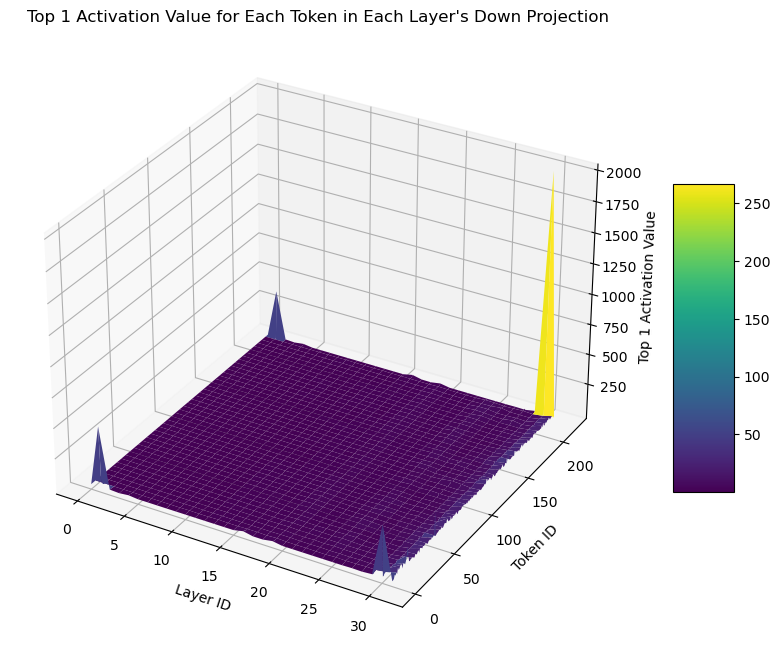

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# 繪製 down_proj 層的 top1 值
token_ids = range(219)
layer_ids = range(32)
top1_values_matrix = []

for i in layer_ids:
    layer_name = f"model.layers.{i}.mlp.down_proj"
    if layer_name in top3_act_scales_all_4bit:
        top1_values = top3_act_scales_all_4bit[layer_name][0][:, 0]  # 取出 top1 值
        top1_values_matrix.append(top1_values.cpu().numpy())  # 將值轉換為 numpy 並添加到矩陣中

top1_values_matrix = np.array(top1_values_matrix)

# 創建三維圖表
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 準備數據
X, Y = np.meshgrid(layer_ids, token_ids)
Z = top1_values_matrix.T  # 轉置矩陣以匹配 X 和 Y 的形狀

# 繪製曲面
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# 添加標籤和標題
ax.set_xlabel('Layer ID')
ax.set_ylabel('Token ID')
ax.set_zlabel('Top 1 Activation Value')
ax.set_title('Top 1 Activation Value for Each Token in Each Layer\'s Down Projection')

# 添加顏色條
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

#### text gen

In [20]:
from transformers import AutoModelForCausalLM, LlamaTokenizer, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
tokenizer = AutoTokenizer.from_pretrained("../../llama-2-7b-hf")

model_attn_only_4bit.eval()
model_attn_only_4bit = model_attn_only_4bit.to(device)

input_text = "explain what is AI"
inputs = tokenizer(input_text, return_tensors="pt",add_special_tokens=True).to(device)

output = model_attn_only_4bit.generate(
    inputs.input_ids,
    max_length=50,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
)

generated_text = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print("Generated text:", generated_text)

Using device: cuda
Generated text: ['explain what is AI\n\n###\n\n108\n\nS Hinweis-s\n\nB f\nG\n\nMost of the\n-\n\nR\n(\nB)\nRating the most-ish']


## FP16 Model Perplexity

Let's first check the performance of the original FP16 model.

In [14]:
model_fp16 = LlamaForCausalLM.from_pretrained(
    "../../llama-2-7b-hf", torch_dtype=torch.float16, device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:

from transformers import AutoModelForCausalLM, LlamaTokenizer, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
# tokenizer = AutoTokenizer.from_pretrained("../../llama-2-7b-hf")

model_fp16.eval()
model_fp16 = model_fp16.to(device)

input_text = "explain what is AI"
inputs = tokenizer(input_text, return_tensors="pt",add_special_tokens=True).to(device)

output = model_fp16.generate(
    inputs.input_ids,
    max_length=50,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    use_cache=False
)

generated_text = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print("Generated text:", generated_text)

Using device: cuda
Generated text: ['explain what is AI?\n1. Explain what is AI?\n2. Explain what is AI? 2.1. Explain what is AI?\n3. Explain what is AI? ']


In [16]:
ppl_fp16 = evaluator.evaluate(model_fp16)
print(f"Original model (fp16) perplexity: {ppl_fp16}")

Evaluating...: 100%|██████████| 40/40 [00:18<00:00,  2.11it/s]


Original model (fp16) perplexity: 5.823019027709961


We then quantize the model to W8A8 and check the performance.

## Naive W8A8 Quantized Model Perplexity

In [17]:
model_w8a8 = quantize_llama_like(model_fp16)
print(model_w8a8)

KeyboardInterrupt: 

In [13]:
from transformers import AutoModelForCausalLM, LlamaTokenizer, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
# tokenizer = AutoTokenizer.from_pretrained("../../llama-2-7b-hf")

model_w8a8.eval()
model_w8a8 = model_w8a8.to(device)

input_text = "explain what is AI"
inputs = tokenizer(input_text, return_tensors="pt",add_special_tokens=True).to(device)

output = model_w8a8.generate(
    inputs.input_ids,
    max_length=100,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    use_cache=False
)

generated_text = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print("Generated text:", generated_text)

Using device: cuda
Generated text: ['explain what is AI I don’t know who the hell. Unterscheidung 4519465.doc 15.jpg Mitarbeit Dus2022018802010010202001010101010000010001010110101010101010101010']


In [7]:
ppl_w8a8 = evaluator.evaluate(model_w8a8)
print(f"Naive W8A8 quantized model perplexity: {ppl_w8a8}")

Evaluating...: 100%|██████████| 40/40 [00:07<00:00,  5.02it/s]

Naive W8A8 quantized model perplexity: 5.931240558624268


We can see there is a perplexity increase. We then use SmoothQuant to quantize the model and check the performance.

## Naive W4A4 attn W8A8 MLP


In [5]:
model_w4a4 = quantize_llama_like(model_fp16)
print(model_w4a4)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (up_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
         

In [8]:
ppl_w4a4 = evaluator.evaluate(model_w4a4)
print(f"Naive W8A8 quantized model perplexity: {ppl_w4a4}")

Evaluating...: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s]

Naive W8A8 quantized model perplexity: 811.0993041992188


## SmoothQuant W8A8 Quantized Model Perplexity

In [4]:
model = LlamaForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf", torch_dtype=torch.float16, device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:

act_scales = torch.load("../act_scales/llama-2-7b.pt")
smooth_lm(model, act_scales, 0.85)
model_smoothquant_w8a8 = quantize_llama_like(model)
print(model_smoothquant_w8a8)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (up_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
         

We can see the smoothed model has a lower perplexity which is close to the FP16 model's. This is because SmoothQuant smooths the outliers in activations and balances the quantization difficulty of activations and weights.

In [12]:
from transformers import AutoModelForCausalLM, LlamaTokenizer, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
tokenizer = AutoTokenizer.from_pretrained("../../llama-2-7b-hf")

model_smoothquant_w8a8.eval()
model_smoothquant_w8a8 = model_smoothquant_w8a8.to(device)

input_text = "explain what is AI"
inputs = tokenizer(input_text, return_tensors="pt",add_special_tokens=True).to(device)

output = model_smoothquant_w8a8.generate(
    inputs.input_ids,
    max_length=50,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
)

generated_text = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print("Generated text:", generated_text)

Using device: cuda
Generated text: ['explain what is AI\nЉ everybodyК everybodyу��.\nIn the first place.\nThe only.\nA.\nI.\nR nobody’s.\nIn the name of the first.\nF.\nH']


In [9]:
ppl_smoothquant_w8a8 = evaluator.evaluate(model_smoothquant_w8a8)
print(f"SmoothQuant W8A8 quantized model perplexity: {ppl_smoothquant_w8a8}")

Evaluating...: 100%|██████████| 40/40 [00:08<00:00,  4.49it/s]

SmoothQuant W8A8 quantized model perplexity: 5.85634183883667


In [14]:
print(model_fp16)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (up_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
         

In [4]:
model_fp16 = LlamaForCausalLM.from_pretrained(
    "../../llama2-7b-hf", torch_dtype=torch.float16, device_map="auto"
)
act_scales = torch.load("../act_scales/llama-2-7b.pt")
smooth_lm(model_fp16, act_scales, 0.85)
model_smoothquant_w4a4 = quantize_llama_like(model_fp16)
print(model_smoothquant_w4a4)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (k_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (v_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (o_proj): W4A4Linear(4096, 4096, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
          (up_proj): W8A8Linear(4096, 11008, bias=False, weight_quant=per_channel, act_quant=per_token, output_quant=None)
         

In [ ]:
ppl_smoothquant_w4a4 = evaluator.evaluate(model_smoothquant_w4a4)
print(f"SmoothQuant W8A8 quantized model perplexity: {ppl_smoothquant_w4a4}")

Evaluating...: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]

SmoothQuant W8A8 quantized model perplexity: 499.2110290527344


: 

In [12]:
print(act_scales)

{'model.layers.0.self_attn.q_proj': tensor([0.1150, 0.0492, 0.0074,  ..., 0.0454, 0.0423, 0.0233]), 'model.layers.0.self_attn.k_proj': tensor([0.1150, 0.0492, 0.0074,  ..., 0.0454, 0.0423, 0.0233]), 'model.layers.0.self_attn.v_proj': tensor([0.1150, 0.0492, 0.0074,  ..., 0.0454, 0.0423, 0.0233]), 'model.layers.0.self_attn.o_proj': tensor([0.0191, 0.0346, 0.0181,  ..., 0.0137, 0.0127, 0.0158]), 'model.layers.0.mlp.gate_proj': tensor([0.1866, 0.1777, 0.1694,  ..., 0.1953, 0.1864, 0.1858]), 'model.layers.0.mlp.up_proj': tensor([0.1866, 0.1777, 0.1694,  ..., 0.1953, 0.1864, 0.1858]), 'model.layers.0.mlp.down_proj': tensor([0.1345, 0.0787, 0.2124,  ..., 0.2271, 0.0812, 0.4741]), 'model.layers.1.self_attn.q_proj': tensor([0.3853, 0.3708, 0.3867,  ..., 0.2445, 0.3130, 0.2749]), 'model.layers.1.self_attn.k_proj': tensor([0.3853, 0.3708, 0.3867,  ..., 0.2445, 0.3130, 0.2749]), 'model.layers.1.self_attn.v_proj': tensor([0.3853, 0.3708, 0.3867,  ..., 0.2445, 0.3130, 0.2749]), 'model.layers.1.self